In [330]:
%matplotlib inline

from datetime import datetime
import pandas as pd
import pandas_datareader.data as web

# replaces pyfinance.ols.PandasRollingOLS (no longer maintained)
from statsmodels.regression.rolling import RollingOLS
import statsmodels.api as sm

import matplotlib.pyplot as plt
import seaborn as sns

In [331]:
import warnings
warnings.filterwarnings('ignore')

In [332]:
sns.set_style('whitegrid')
idx = pd.IndexSlice

In [333]:
DATA_STORE = '/Users/Massimiliano/assets.h5'

In [334]:
START = 2000
END = 2018

In [335]:
with pd.HDFStore(DATA_STORE) as store:
    prices = (store['quandl/wiki/prices']
              .loc[idx[str(START):str(END), :], 'adj_close']
              .unstack('ticker'))
    stocks = store['us_equities/stocks'].loc[:, ['mktcap', 'ipoyear', 'sector']]

In [336]:
stocks.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4314 entries, AACG to ZYXI
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   mktcap   4302 non-null   float64
 1   ipoyear  2622 non-null   float64
 2   sector   4184 non-null   object 
dtypes: float64(2), object(1)
memory usage: 134.8+ KB


In [337]:
prices.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4706 entries, 2000-01-03 to 2018-03-27
Columns: 3199 entries, A to ZUMZ
dtypes: float64(3199)
memory usage: 114.9 MB


In [338]:
stocks.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4314 entries, AACG to ZYXI
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   mktcap   4302 non-null   float64
 1   ipoyear  2622 non-null   float64
 2   sector   4184 non-null   object 
dtypes: float64(2), object(1)
memory usage: 134.8+ KB


In [339]:
#Remove stocks duplicates and align index names for later joining.
stocks = stocks[~stocks.index.duplicated()]
stocks.index.name = 'ticker'

#Get tickers with both price information and metadata
shared = prices.columns.intersection(stocks.index)
stocks = stocks.loc[shared, :]
stocks.info()

<class 'pandas.core.frame.DataFrame'>
Index: 843 entries, AAL to ZUMZ
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   mktcap   843 non-null    float64
 1   ipoyear  447 non-null    float64
 2   sector   836 non-null    object 
dtypes: float64(2), object(1)
memory usage: 26.3+ KB


In [340]:
#resamplemonthlyreturns
monthly_prices = prices.resample('M').last()

In [341]:
monthly_prices.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 219 entries, 2000-01-31 to 2018-03-31
Freq: M
Columns: 3199 entries, A to ZUMZ
dtypes: float64(3199)
memory usage: 5.3 MB


In [342]:
#To capture time series dynamics that reflect, for example, momentum patterns, 
#we compute historical returns using the method .pct_change(n_periods), 
#that is, returns over various monthly periods as identified by lags.

#We then convert the wide result back to long format with the .stack() method, 
#use .pipe() to apply the .clip() method to the resulting DataFrame, and 
#Finally, we normalize returns using the geometric average. 
#winsorize returns at the [1%, 99%] levels; that is, we cap outliers at these percentiles.
#After using .swaplevel() to change the order of the MultiIndex levels, 
#we obtain compounded monthly returns for six periods ranging from 1 to 12 months:

In [343]:
outlier_cutoff = 0.01
data = pd.DataFrame()
lags = [1, 2, 3, 6, 9, 12]
for lag in lags:
    data[f'return_{lag}m'] = (monthly_prices
                           .pct_change(lag)
                           .stack()
                           .pipe(lambda x: x.clip(lower=x.quantile(outlier_cutoff),
                                                  upper=x.quantile(1-outlier_cutoff)))
                           .add(1)
                           .pow(1/lag)
                           .sub(1)
                           )
data = data.swaplevel().dropna()
data.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 521806 entries, ('A', Timestamp('2001-01-31 00:00:00')) to ('ZUMZ', Timestamp('2018-03-31 00:00:00'))
Data columns (total 6 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   return_1m   521806 non-null  float64
 1   return_2m   521806 non-null  float64
 2   return_3m   521806 non-null  float64
 3   return_6m   521806 non-null  float64
 4   return_9m   521806 non-null  float64
 5   return_12m  521806 non-null  float64
dtypes: float64(6)
memory usage: 26.0+ MB


In [344]:
#Drop stocks with less than 10 yrs of returns

In [345]:
min_obs = 120
nobs = data.groupby(level='ticker').size()
keep = nobs[nobs>min_obs].index

data = data.loc[idx[keep,:], :]
data.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 465935 entries, ('A', Timestamp('2001-01-31 00:00:00')) to ('ZUMZ', Timestamp('2018-03-31 00:00:00'))
Data columns (total 6 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   return_1m   465935 non-null  float64
 1   return_2m   465935 non-null  float64
 2   return_3m   465935 non-null  float64
 3   return_6m   465935 non-null  float64
 4   return_9m   465935 non-null  float64
 5   return_12m  465935 non-null  float64
dtypes: float64(6)
memory usage: 23.3+ MB


In [346]:
data.describe()

,return_1m,return_2m,return_3m,return_6m,return_9m,return_12m
count,465935.000000,465935.000000,465935.000000,465935.000000,465935.000000,465935.000000
mean,0.011694,0.008454,0.007306,0.006036,0.005542,0.005285
std,0.117872,0.084059,0.069195,0.050674,0.041919,0.036635
min,-0.343442,-0.269341,-0.229978,-0.175426,-0.145071,-0.125787
25%,-0.046679,-0.031096,-0.024413,-0.015632,-0.012035,-0.009962
50%,0.006369,0.007476,0.007810,0.008024,0.007924,0.007852
75%,0.065314,0.048890,0.041722,0.031742,0.027062,0.024439
max,0.449446,0.294075,0.230064,0.159207,0.128147,0.108809


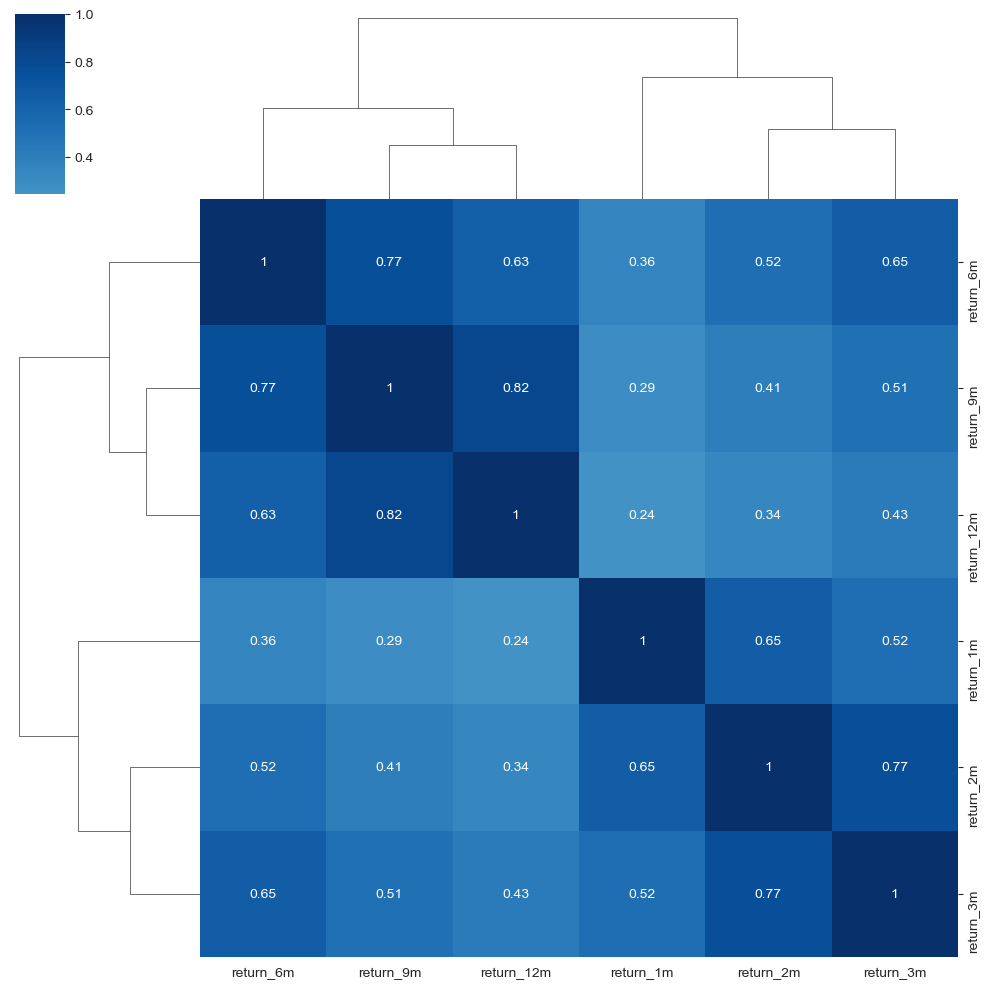

In [347]:
# cmap = sns.diverging_palette(10, 220, as_cmap=True)
sns.clustermap(data.corr('spearman'), annot=True, center=0, cmap='Blues');

In [348]:
#n of tickers left
data.index.get_level_values('ticker').nunique()

2385

In [349]:
#the five Fama—French factors, namely market risk, size, value, operating profitability,
# and investment have been shown empirically to explain asset returns and are commonly used 
# to assess the risk/return profile of portfolios. Hence, it is natural to include past 
# factor exposures as financial features in models that aim to predict future returns.We can access 
# the historical factor returns using the pandas-datareader and estimate historical exposures 
# using the RollingOLS rolling linear regression functionality in the statsmodels library as follows:
# Use Fama-French research factors to estimate the factor exposures of the stock in the dataset to 
# the 5 factors market risk, size, value, operating profitability and investment.

In [350]:
factors = ['Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA']
factor_data = web.DataReader('F-F_Research_Data_5_Factors_2x3', 'famafrench', start='2000')[0].drop('RF', axis=1)
factor_data.index = factor_data.index.to_timestamp()
factor_data = factor_data.resample('M').last().div(100)
factor_data.index.name = 'date'
factor_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 284 entries, 2000-01-31 to 2023-08-31
Freq: M
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Mkt-RF  284 non-null    float64
 1   SMB     284 non-null    float64
 2   HML     284 non-null    float64
 3   RMW     284 non-null    float64
 4   CMA     284 non-null    float64
dtypes: float64(5)
memory usage: 13.3 KB


In [351]:
factor_data = factor_data.join(data['return_1m']).sort_index()
factor_data.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 465935 entries, ('A', Timestamp('2001-01-31 00:00:00')) to ('ZUMZ', Timestamp('2018-03-31 00:00:00'))
Data columns (total 6 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   Mkt-RF     465935 non-null  float64
 1   SMB        465935 non-null  float64
 2   HML        465935 non-null  float64
 3   RMW        465935 non-null  float64
 4   CMA        465935 non-null  float64
 5   return_1m  465935 non-null  float64
dtypes: float64(6)
memory usage: 23.3+ MB


In [352]:
T = 24
betas = (factor_data.groupby(level='ticker',
                             group_keys=False)
         .apply(lambda x: RollingOLS(endog=x.return_1m,
                                     exog=sm.add_constant(x.drop('return_1m', axis=1)),
                                     window=min(T, x.shape[0]-1))
                .fit(params_only=True)
                .params
                .drop('const', axis=1)))

In [353]:
betas.describe().join(betas.sum(1).describe().to_frame('total'))

,Mkt-RF,SMB,HML,RMW,CMA,total
count,411080.000000,411080.000000,411080.000000,4.110800e+05,411080.000000,465935.000000
mean,0.972738,0.639852,0.113687,-9.520483e-02,0.018514,1.455379
std,0.949609,1.307478,1.668164,1.994570e+00,2.233348,3.436439
min,-9.839408,-10.514475,-16.972496,-2.482626e+01,-19.912303,-35.400302
25%,0.428533,-0.120422,-0.732065,-1.049914e+00,-1.099445,0.000000
50%,0.918065,0.542867,0.072700,2.126248e-15,0.024009,1.128157
75%,1.458323,1.338423,0.948059,9.521193e-01,1.153939,3.163461
max,10.926073,10.852749,15.723984,1.932599e+01,21.450389,39.453020


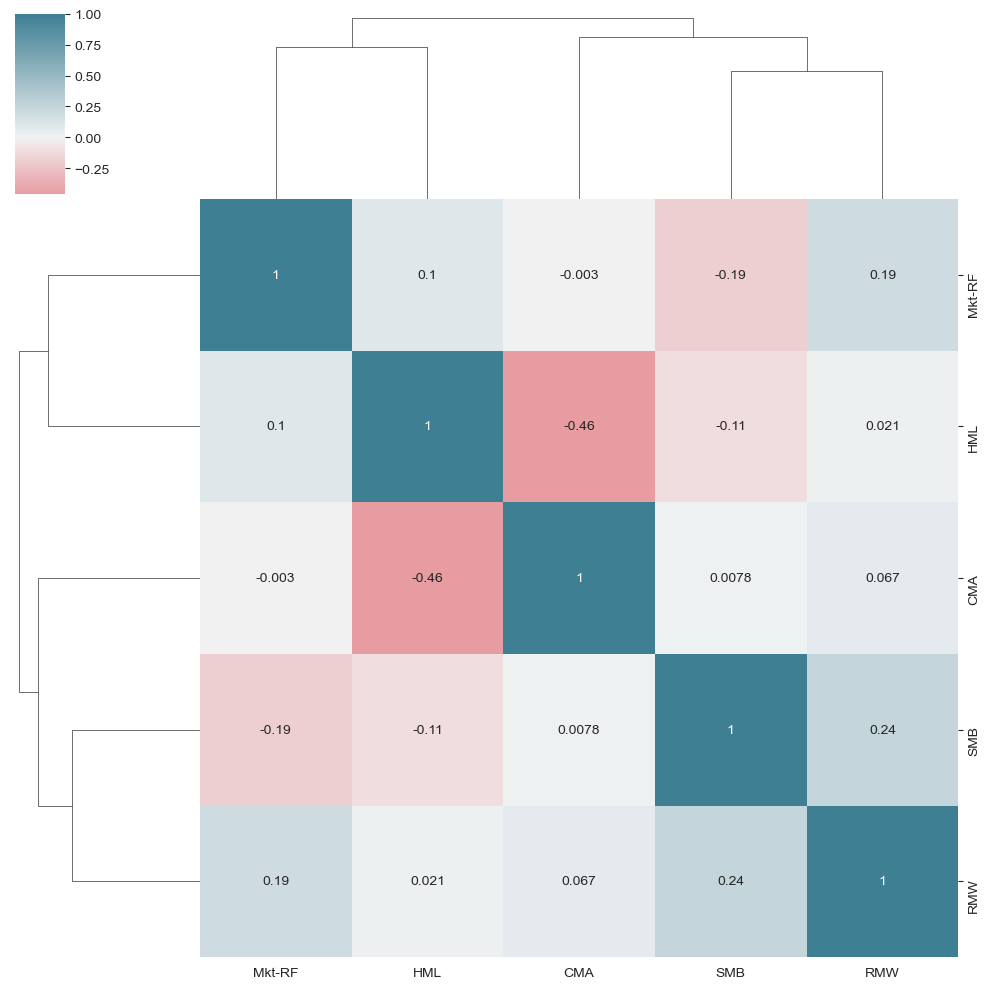

In [354]:
cmap = sns.diverging_palette(10, 220, as_cmap=True)
sns.clustermap(betas.corr(), annot=True, cmap=cmap, center=0)

In [355]:
data = (data
        .join(betas
              .groupby(level='ticker')
              .shift()))
data.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 465935 entries, ('A', Timestamp('2001-01-31 00:00:00')) to ('ZUMZ', Timestamp('2018-03-31 00:00:00'))
Data columns (total 11 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   return_1m   465935 non-null  float64
 1   return_2m   465935 non-null  float64
 2   return_3m   465935 non-null  float64
 3   return_6m   465935 non-null  float64
 4   return_9m   465935 non-null  float64
 5   return_12m  465935 non-null  float64
 6   Mkt-RF      408695 non-null  float64
 7   SMB         408695 non-null  float64
 8   HML         408695 non-null  float64
 9   RMW         408695 non-null  float64
 10  CMA         408695 non-null  float64
dtypes: float64(11)
memory usage: 57.2+ MB


In [356]:
data.loc[:, factors] = data.groupby('ticker')[factors].transform(lambda x: x.fillna(x.mean()))
data.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 465935 entries, ('A', Timestamp('2001-01-31 00:00:00')) to ('ZUMZ', Timestamp('2018-03-31 00:00:00'))
Data columns (total 11 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   return_1m   465935 non-null  float64
 1   return_2m   465935 non-null  float64
 2   return_3m   465935 non-null  float64
 3   return_6m   465935 non-null  float64
 4   return_9m   465935 non-null  float64
 5   return_12m  465935 non-null  float64
 6   Mkt-RF      465935 non-null  float64
 7   SMB         465935 non-null  float64
 8   HML         465935 non-null  float64
 9   RMW         465935 non-null  float64
 10  CMA         465935 non-null  float64
dtypes: float64(11)
memory usage: 57.2+ MB


In [357]:
#We can use these results to compute momentum factors based on the difference between 
# returns over longer periods and the most recent monthly return, as well as for 
# the difference between 3 and 12 month returns as follows:

In [358]:
for lag in [2,3,6,9,12]:
        data[f'momentum_{lag}'] = data[f'return_{lag}m'].sub(data.return_1m)
        data[f'momentum_3_12'] = data[f'return_12m'].sub(data.return_3m)

In [359]:
dates = data.index.get_level_values('date')
data['year'] = dates.year
data['month'] = dates.month

In [360]:
#Lagged returns
#To use lagged values as input variables or features associated with the current observations, 
#we use the .shift() method to move historical returns up to the current period:

In [361]:
for t in range(1, 7):
    data[f'return_1m_t-{t}'] = data.groupby(level='ticker').return_1m.shift(t)
data.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 465935 entries, ('A', Timestamp('2001-01-31 00:00:00')) to ('ZUMZ', Timestamp('2018-03-31 00:00:00'))
Data columns (total 25 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   return_1m      465935 non-null  float64
 1   return_2m      465935 non-null  float64
 2   return_3m      465935 non-null  float64
 3   return_6m      465935 non-null  float64
 4   return_9m      465935 non-null  float64
 5   return_12m     465935 non-null  float64
 6   Mkt-RF         465935 non-null  float64
 7   SMB            465935 non-null  float64
 8   HML            465935 non-null  float64
 9   RMW            465935 non-null  float64
 10  CMA            465935 non-null  float64
 11  momentum_2     465935 non-null  float64
 12  momentum_3_12  465935 non-null  float64
 13  momentum_3     465935 non-null  float64
 14  momentum_6     465935 non-null  float64
 15  momentum_9     465935 non-null  float64
 16  

In [362]:
#Target: Holding Period Returns
#Similarly, to compute returns for various holding periods, we use the normalized period returns 
# computed previously and shift them back to align them with the current financial features

In [363]:
for t in [1,2,3,6,12]:
    data[f'target_{t}m'] = data.groupby(level='ticker')[f'return_{t}m'].shift(-t)

In [364]:
cols = ['target_1m',
        'target_2m',
        'target_3m', 
        'return_1m',
        'return_2m',
        'return_3m',
        'return_1m_t-1',
        'return_1m_t-2',
        'return_1m_t-3']

data[cols].dropna().sort_index().head(10)

target_1m  target_2m  target_3m  return_1m  return_2m  \
ticker date                                                                
A      2001-04-30  -0.140220  -0.087246  -0.098192   0.269444   0.040966   
       2001-05-31  -0.031008  -0.076414  -0.075527  -0.140220   0.044721   
       2001-06-30  -0.119692  -0.097014  -0.155847  -0.031008  -0.087246   
       2001-07-31  -0.073750  -0.173364  -0.080114  -0.119692  -0.076414   
       2001-08-31  -0.262264  -0.083279   0.009593  -0.073750  -0.097014   
       2001-09-30   0.139130   0.181052   0.134010  -0.262264  -0.173364   
       2001-10-31   0.224517   0.131458   0.108697   0.139130  -0.083279   
       2001-11-30   0.045471   0.054962   0.045340   0.224517   0.181052   
       2001-12-31   0.064539   0.045275   0.070347   0.045471   0.131458   
       2002-01-31   0.026359   0.073264  -0.003306   0.064539   0.054962   

                   return_3m  return_1m_t-1  return_1m_t-2  return_1m_t-3  
ticker date                                                                
A      2001-04-30  -0.105747      -0.146389      -0.340055      -0.003653  
       2001-05-31  -0.023317       0.269444      -0.146389      -0.340055  
       2001-06-30   0.018842      -0.140220       0.269444      -0.146389  
       2001-07-31  -0.098192      -0.031008      -0.140220       0.269444  
       2001-08-31  -0.075527      -0.119692      -0.031008      -0.140220  
       2001-09-30  -0.155847      -0.073750      -0.119692      -0.031008  
       2001-10-31  -0.080114      -0.262264      -0.073750      -0.119692  
       2001-11-30   0.009593       0.139130      -0.262264      -0.073750  
       2001-12-31   0.134010       0.224517       0.139130      -0.262264  
       2002-01-31   0.108697       0.045471       0.224517       0.139130

In [365]:
data.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 465935 entries, ('A', Timestamp('2001-01-31 00:00:00')) to ('ZUMZ', Timestamp('2018-03-31 00:00:00'))
Data columns (total 30 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   return_1m      465935 non-null  float64
 1   return_2m      465935 non-null  float64
 2   return_3m      465935 non-null  float64
 3   return_6m      465935 non-null  float64
 4   return_9m      465935 non-null  float64
 5   return_12m     465935 non-null  float64
 6   Mkt-RF         465935 non-null  float64
 7   SMB            465935 non-null  float64
 8   HML            465935 non-null  float64
 9   RMW            465935 non-null  float64
 10  CMA            465935 non-null  float64
 11  momentum_2     465935 non-null  float64
 12  momentum_3_12  465935 non-null  float64
 13  momentum_3     465935 non-null  float64
 14  momentum_6     465935 non-null  float64
 15  momentum_9     465935 non-null  float64
 16  

In [366]:
#Create age proxy
#We use quintiles of IPO year as a proxy for company age.

In [367]:
data = (data
        .join(pd.qcut(stocks['ipoyear'], q=5, labels=list(range(1, 6)))
            .astype(float)
            .fillna(0)
            .astype(int)
            .to_frame('age')))
data.age = data.age.fillna(-1)

In [368]:
#Create dynamic size proxy
#We use the marketcap information from the NASDAQ ticker info to create a size proxy.

In [369]:
stocks.info()

<class 'pandas.core.frame.DataFrame'>
Index: 843 entries, AAL to ZUMZ
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   mktcap   843 non-null    float64
 1   ipoyear  447 non-null    float64
 2   sector   836 non-null    object 
dtypes: float64(2), object(1)
memory usage: 58.6+ KB


In [370]:
#Market cap information is tied to currrent prices. We create an adjustment factor 
#to have the values reflect lower historical prices for each individual stock:

In [371]:
size_factor = (monthly_prices
            .loc[data.index.get_level_values('date').unique(),
                data.index.get_level_values('ticker').unique()]
            .sort_index(ascending=False)
            .pct_change()
            .fillna(0)
            .add(1)
            .cumprod())
size_factor.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 207 entries, 2018-03-31 to 2001-01-31
Columns: 2385 entries, A to ZUMZ
dtypes: float64(2385)
memory usage: 3.8 MB


In [372]:
cols_list=size_factor.columns.to_list()
print(cols_list)

['A', 'AAL', 'AAN', 'AAON', 'AAP', 'AAPL', 'AAWW', 'ABAX', 'ABC', 'ABCB', 'ABCO', 'ABFS', 'ABG', 'ABM', 'ABMD', 'ABT', 'ACAD', 'ACAS', 'ACAT', 'ACC', 'ACCL', 'ACCO', 'ACE', 'ACET', 'ACFN', 'ACGL', 'ACHC', 'ACHN', 'ACI', 'ACIW', 'ACLS', 'ACN', 'ACO', 'ACOR', 'ACTG', 'ACXM', 'ADBE', 'ADC', 'ADI', 'ADM', 'ADP', 'ADS', 'ADSK', 'ADTN', 'ADVS', 'AE', 'AEC', 'AEE', 'AEGN', 'AEIS', 'AEL', 'AEO', 'AEP', 'AEPI', 'AES', 'AET', 'AF', 'AFAM', 'AFFX', 'AFG', 'AFL', 'AFOP', 'AFSI', 'AGCO', 'AGEN', 'AGII', 'AGM', 'AGN', 'AGO', 'AGX', 'AGYS', 'AHL', 'AHS', 'AHT', 'AI', 'AIG', 'AIMC', 'AIN', 'AINV', 'AIQ', 'AIR', 'AIRM', 'AIT', 'AIV', 'AIZ', 'AJG', 'AKAM', 'AKR', 'AKRX', 'AKS', 'ALB', 'ALCO', 'ALE', 'ALG', 'ALGN', 'ALGT', 'ALJ', 'ALK', 'ALKS', 'ALL', 'ALNY', 'ALOG', 'ALR', 'ALTR', 'ALX', 'ALXN', 'AMAG', 'AMAT', 'AMCC', 'AMD', 'AME', 'AMED', 'AMG', 'AMGN', 'AMKR', 'AMNB', 'AMP', 'AMRI', 'AMSC', 'AMSF', 'AMSG', 'AMSWA', 'AMT', 'AMTD', 'AMWD', 'AMZG', 'AMZN', 'AN', 'ANAD', 'ANAT', 'ANCX', 'ANDE', 'ANF', 'A

In [373]:
print(stocks)

              mktcap  ipoyear                  sector
ticker                                               
AAL     9.218958e+09      NaN  Consumer Discretionary
AAOI    3.755862e+08   2013.0              Technology
AAON    5.282579e+09      NaN             Industrials
AAPL    2.812442e+12   1980.0              Technology
ABCB    2.691592e+09   1994.0                 Finance
...              ...      ...                     ...
Z       1.195562e+10      NaN  Consumer Discretionary
ZBRA    1.313107e+10   1991.0             Industrials
ZEUS    5.535100e+08   1994.0             Industrials
ZION    5.156191e+09      NaN                 Finance
ZUMZ    3.473393e+08   2005.0  Consumer Discretionary

[843 rows x 3 columns]


In [374]:
stocks=stocks.reset_index()

In [375]:
stocks.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 843 entries, 0 to 842
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   ticker   843 non-null    object 
 1   mktcap   843 non-null    float64
 2   ipoyear  447 non-null    float64
 3   sector   836 non-null    object 
dtypes: float64(2), object(2)
memory usage: 26.5+ KB


In [376]:
new_stocks = stocks.loc[~stocks['ticker'].isin(cols_list)]

In [377]:
msize = (size_factor.mul(new_stocks).dropna(axis=1, how='all'))

In [378]:
#Create Size indicator as deciles per period
#Compute size deciles per month:

In [379]:
data['msize'] = (msize
                .apply(lambda x: pd.qcut(x, q=10, labels=list(range(1, 11)))
                        .astype(int), axis=1)
                .stack()
                .swaplevel())
data.msize = data.msize.fillna(-1)
data.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 465935 entries, ('A', Timestamp('2001-01-31 00:00:00')) to ('ZUMZ', Timestamp('2018-03-31 00:00:00'))
Data columns (total 32 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   return_1m      465935 non-null  float64
 1   return_2m      465935 non-null  float64
 2   return_3m      465935 non-null  float64
 3   return_6m      465935 non-null  float64
 4   return_9m      465935 non-null  float64
 5   return_12m     465935 non-null  float64
 6   Mkt-RF         465935 non-null  float64
 7   SMB            465935 non-null  float64
 8   HML            465935 non-null  float64
 9   RMW            465935 non-null  float64
 10  CMA            465935 non-null  float64
 11  momentum_2     465935 non-null  float64
 12  momentum_3_12  465935 non-null  float64
 13  momentum_3     465935 non-null  float64
 14  momentum_6     465935 non-null  float64
 15  momentum_9     465935 non-null  float64
 16  

In [380]:
new_stocks=new_stocks.set_index('ticker')

In [381]:
#Combine data

In [382]:
data = data.join(new_stocks[['sector']])
data.sector = data.sector.fillna('Unknown')
data.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 465935 entries, ('A', Timestamp('2001-01-31 00:00:00')) to ('ZUMZ', Timestamp('2018-03-31 00:00:00'))
Data columns (total 33 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   return_1m      465935 non-null  float64
 1   return_2m      465935 non-null  float64
 2   return_3m      465935 non-null  float64
 3   return_6m      465935 non-null  float64
 4   return_9m      465935 non-null  float64
 5   return_12m     465935 non-null  float64
 6   Mkt-RF         465935 non-null  float64
 7   SMB            465935 non-null  float64
 8   HML            465935 non-null  float64
 9   RMW            465935 non-null  float64
 10  CMA            465935 non-null  float64
 11  momentum_2     465935 non-null  float64
 12  momentum_3_12  465935 non-null  float64
 13  momentum_3     465935 non-null  float64
 14  momentum_6     465935 non-null  float64
 15  momentum_9     465935 non-null  float64
 16  

In [383]:
with pd.HDFStore(DATA_STORE) as store:
    store.put('engineered_features', data.sort_index().loc[idx[:, :datetime(2018, 3, 1)], :])
    print(store.info())

<class 'pandas.io.pytables.HDFStore'>
File path: /Users/Massimiliano/assets.h5
/engineered_features            frame        (shape->[463550,33])  
/quandl/wiki/prices             frame        (shape->[15389314,12])
/sp500/fred                     frame        (shape->[2610,1])     
/sp500/stocks                   frame        (shape->[503,8])      
/us_equities/stocks             frame        (shape->[4314,10])    


In [384]:
#create dummy variables
dummy_data = pd.get_dummies(data,
                            columns=['year','month', 'msize', 'age',  'sector'],
                            prefix=['year','month', 'msize', 'age', ''],
                            prefix_sep=['_', '_', '_', '_', ''])
dummy_data = dummy_data.rename(columns={c:c.replace('.0', '') for c in dummy_data.columns})
dummy_data.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 465935 entries, ('A', Timestamp('2001-01-31 00:00:00')) to ('ZUMZ', Timestamp('2018-03-31 00:00:00'))
Data columns (total 67 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   return_1m      465935 non-null  float64
 1   return_2m      465935 non-null  float64
 2   return_3m      465935 non-null  float64
 3   return_6m      465935 non-null  float64
 4   return_9m      465935 non-null  float64
 5   return_12m     465935 non-null  float64
 6   Mkt-RF         465935 non-null  float64
 7   SMB            465935 non-null  float64
 8   HML            465935 non-null  float64
 9   RMW            465935 non-null  float64
 10  CMA            465935 non-null  float64
 11  momentum_2     465935 non-null  float64
 12  momentum_3_12  465935 non-null  float64
 13  momentum_3     465935 non-null  float64
 14  momentum_6     465935 non-null  float64
 15  momentum_9     465935 non-null  float64
 16  